# **Github**

In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
personal_token = user_secrets.get_secret("GITHUB_PAT")

In [2]:
!git clone https://{personal_token}@github.com/Mohamed-Mohamed-Ibrahim/NLP-lab-2.git /kaggle/working/NLP-lab-2

Cloning into '/kaggle/working/NLP-lab-2'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5/5), done.


In [3]:
%cd /kaggle/working/NLP-lab-2

/kaggle/working/NLP-lab-2


In [4]:
!git checkout word2vec

Branch 'word2vec' set up to track remote branch 'word2vec' from 'origin'.
Switched to a new branch 'word2vec'


# **Import Libraries**

In [5]:
# === Standard Library ===
import os
import warnings
from collections import Counter

# === Third-Party Libraries ===
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# === PyTorch ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# **Ignore Warnings**

In [6]:
warnings.filterwarnings('ignore')

# **Load Dataset**

In [7]:
import string

def load_corpus():
    translator = str.maketrans('', '', string.punctuation)
    
    all_sentences = []
    dataset = load_dataset('lhoestq/conll2003')

    for split in ['train', 'validation', 'test']:
        for example in dataset[split]:
            cleaned_tokens = []
            for token in example['tokens']:
                token = token.lower().translate(translator)
                if token != '':  
                    cleaned_tokens.append(token)
            all_sentences.append(cleaned_tokens)

    return all_sentences

In [8]:
corpus = load_corpus()

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/281k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

# **Define Parameters**

In [9]:
# === Hyperparameters ===
embed_dim = 100
context_size = 5
num_negative_samples = 5
lr = 3e-3
num_epochs = 100

# === Device Setup ===
device = "cuda" if torch.cuda.is_available() else "cpu"

# **Define Mapping of Word to Index Function**

In [48]:
from collections import Counter

def build_vocab_mapping(corpus, min_count = 5):
    
    word_counts = Counter()
    for sentence in corpus:
        word_counts.update(sentence)
    
    vocab = [word for word, count in word_counts.items() if count >= min_count]
    
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for idx, word in enumerate(vocab)}

    word_freqs = [word_counts[word] for word in vocab]
    
    return word_to_idx, idx_to_word, word_freqs, len(vocab)

In [49]:
word_to_idx, idx_to_word, word_freqs, vocab_size = build_vocab_mapping(corpus)

# **Define Function That Generate Negative Samples**

In [12]:
import numpy as np, torch, random

def get_unigram_distribution(corpus, word_freqs, word_to_idx, t = 1e-5, power = 0.75):
    word_freqs, total_words = np.array(word_freqs), sum(word_freqs)
    frac_freqs = word_freqs / total_words
    keep_prob = np.minimum((np.sqrt(frac_freqs / t) + 1) * (t / frac_freqs), 1.0)

    indexed_corpus, discarded = [], 0
    for s in corpus:
        idx_s = [word_to_idx[w] for w in s if w in word_to_idx and random.random() < keep_prob[word_to_idx[w]]]
        discarded += len(s) - len(idx_s)
        if idx_s: indexed_corpus.append(idx_s)

    distribution = (word_freqs ** power) / np.sum(word_freqs ** power)
    return indexed_corpus, torch.tensor(distribution, dtype=torch.float)

In [13]:
indexed_corpus, noise_distribution = get_unigram_distribution(corpus, word_freqs, word_to_idx)

# **Define Method That Generate Data**

In [14]:
def generate_training_data(indexed_corpus, context_size):
    data = []
    
    for sentence in indexed_corpus:
        for i in range(len(sentence)):
            context_words =  [sentence[i - j - 1] for j in range(context_size) if i - j - 1 >= 0]
            context_words += [sentence[i + j + 1] for j in range(context_size) if i + j + 1 < len(sentence)]
            
            for context_word in context_words:
                data.append((sentence[i], context_word))
        
    return data

In [15]:
train_data = generate_training_data(indexed_corpus, context_size)

# **Define Custom Dataset**

In [16]:
class Word2VecDataset(Dataset):
    def __init__(self, data):
        self.center_words  = torch.tensor([pair[0] for pair in data], dtype = torch.long)
        self.context_words = torch.tensor([pair[1] for pair in data], dtype = torch.long)

    def __len__(self):
        return len(self.center_words)

    def __getitem__(self, idx):
        return self.center_words[idx], self.context_words[idx]

# **Generate Dataset & Dataloader**

In [17]:
# generate dataset
train_dataset = Word2VecDataset(train_data)

# generate dataloader
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

In [18]:
def get_negative_samples(batch_size, noise_distribution, num_negative_samples, device = 'cuda'):
    # Sample from the noise distribution
    negative_samples = torch.multinomial(noise_distribution, num_negative_samples * batch_size, replacement = True)
    
    # Reshape to (batch_size, num_negative_samples)
    return negative_samples.view(batch_size, num_negative_samples).to(device)

In [19]:
# import numpy as np
# import torch

# def get_unigram_distribution(corpus, word_to_idx):
#     """
#     Converts a corpus of tokenized sentences into indexed_corpus using word_to_idx.
#     Keeps all words (no subsampling or frequency filtering).
#     Returns the full indexed_corpus and None for distribution (since not used).
#     """
#     indexed_corpus = []
#     for s in corpus:
#         idx_s = [word_to_idx[w] for w in s if w in word_to_idx]
#         if idx_s:
#             indexed_corpus.append(idx_s)
#     return indexed_corpus, None

# indexed_corpus, noise_distribution = get_unigram_distribution(corpus, word_to_idx)

# def get_negative_samples(batch_size, vocab_size, num_negative_samples, device='cuda'):
#     """
#     Generates random negative samples uniformly from the vocabulary.
#     """
#     negative_samples = torch.randint(
#         low=0,
#         high=vocab_size,
#         size=(batch_size, num_negative_samples),
#         device=device
#     )
#     return negative_samples

# **Define Model Architecture**

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SkipGramNegSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGramNegSampling, self).__init__()
        self.embed_dim = embed_dim

        self.embeddings = nn.Embedding(vocab_size, embed_dim, sparse = True)
        self.context_embeddings = nn.Embedding(vocab_size, embed_dim, sparse = True)
        self.log_sigmoid = nn.LogSigmoid()
        
        self.init_embeddings()

    def init_embeddings(self):
        init_range = 0.5 / self.embed_dim
        self.embeddings.weight.data.uniform_(-init_range, init_range)
        self.context_embeddings.weight.data.uniform_(-init_range, init_range)

    def forward(self, target, context, negative_samples):
        target_embedding = self.embeddings(target)
        context_embedding = self.context_embeddings(context)
        negative_embeddings = self.context_embeddings(negative_samples)

        positive_score = self.log_sigmoid(torch.sum((target_embedding * context_embedding), dim = 1))
        negative_score = torch.sum(self.log_sigmoid(-torch.bmm(negative_embeddings, target_embedding.unsqueeze(2)).squeeze(2)), dim = 1) 

        total_score = -torch.mean(positive_score + negative_score)
        return total_score

In [21]:
model = SkipGramNegSampling(vocab_size, embed_dim).to(device)
optimizer = optim.SparseAdam(model.parameters(), lr=lr)

best_loss = float('inf')
patience_counter = 0 

training_losses = []

for epoch in range(1, num_epochs + 1):
    model.train(); total_train_loss = 0;
    
    for target, context in tqdm(train_loader):
        target, context = target.long().to(device), context.long().to(device)
        negative_samples = get_negative_samples(target.size(0), noise_distribution, num_negative_samples, device)
        
        optimizer.zero_grad()
        loss = model(target, context, negative_samples)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader); training_losses.append(avg_train_loss)
    print(f"Epoch: {epoch} | Training Loss: {avg_train_loss}")
    
    if avg_train_loss + 0.01 < best_loss:
        best_loss, patience_counter = avg_train_loss, 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("New best model saved.")
    
    else:
        patience_counter += 1
        if patience_counter > 3:
            print(f"Stop at Epoch {epoch}"); break;

100%|██████████| 6472/6472 [00:18<00:00, 348.22it/s]


Epoch: 1 | Training Loss: 2.8642947224736655
New best model saved.


100%|██████████| 6472/6472 [00:18<00:00, 358.68it/s]


Epoch: 2 | Training Loss: 2.4267564700508886
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 360.66it/s]


Epoch: 3 | Training Loss: 2.0493994574943195
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 360.96it/s]


Epoch: 4 | Training Loss: 1.6374911307293936
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 360.11it/s]


Epoch: 5 | Training Loss: 1.322037914452432
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 360.70it/s]


Epoch: 6 | Training Loss: 1.0957007788223005
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 363.14it/s]


Epoch: 7 | Training Loss: 0.9383406748140993
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 360.72it/s]


Epoch: 8 | Training Loss: 0.8269390292253865
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 362.56it/s]


Epoch: 9 | Training Loss: 0.744951904777838
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 361.24it/s]


Epoch: 10 | Training Loss: 0.6817720049280761
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 360.11it/s]


Epoch: 11 | Training Loss: 0.6355783743979536
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 361.60it/s]


Epoch: 12 | Training Loss: 0.5997614008575972
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 360.96it/s]


Epoch: 13 | Training Loss: 0.5679162604128769
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 360.61it/s]


Epoch: 14 | Training Loss: 0.5398975623119968
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 361.51it/s]


Epoch: 15 | Training Loss: 0.5219640336949171
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 359.63it/s]


Epoch: 16 | Training Loss: 0.5026586210431142
New best model saved.


100%|██████████| 6472/6472 [00:18<00:00, 357.82it/s]


Epoch: 17 | Training Loss: 0.4898779941573094
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 362.83it/s]


Epoch: 18 | Training Loss: 0.47812311634955507
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 361.42it/s]


Epoch: 19 | Training Loss: 0.46181669251070034
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 360.87it/s]


Epoch: 20 | Training Loss: 0.4554581686725428


100%|██████████| 6472/6472 [00:17<00:00, 360.67it/s]


Epoch: 21 | Training Loss: 0.44482446285091315
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 362.82it/s]


Epoch: 22 | Training Loss: 0.4371043309092761


100%|██████████| 6472/6472 [00:17<00:00, 363.56it/s]


Epoch: 23 | Training Loss: 0.4320613491580314
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 363.08it/s]


Epoch: 24 | Training Loss: 0.4274784198125228


100%|██████████| 6472/6472 [00:17<00:00, 363.67it/s]


Epoch: 25 | Training Loss: 0.41721409170834256
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 362.50it/s]


Epoch: 26 | Training Loss: 0.4110097946744177


100%|██████████| 6472/6472 [00:17<00:00, 366.63it/s]


Epoch: 27 | Training Loss: 0.405230192938412
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 361.26it/s]


Epoch: 28 | Training Loss: 0.4046216704025036


100%|██████████| 6472/6472 [00:17<00:00, 360.08it/s]


Epoch: 29 | Training Loss: 0.3986438907445748


100%|██████████| 6472/6472 [00:18<00:00, 359.55it/s]


Epoch: 30 | Training Loss: 0.39404645586807663
New best model saved.


100%|██████████| 6472/6472 [00:17<00:00, 363.94it/s]


Epoch: 31 | Training Loss: 0.3882286131326731


100%|██████████| 6472/6472 [00:17<00:00, 363.50it/s]


Epoch: 32 | Training Loss: 0.3900636695613175


100%|██████████| 6472/6472 [00:17<00:00, 361.03it/s]


Epoch: 33 | Training Loss: 0.3881880069734029


100%|██████████| 6472/6472 [00:18<00:00, 356.89it/s]

Epoch: 34 | Training Loss: 0.3857311787709999
Stop at Epoch 34


# **Load The Best Model**

In [22]:
best_model = SkipGramNegSampling(vocab_size, embed_dim)
best_model.load_state_dict(torch.load('best_model.pth') )
best_model.to(device)

SkipGramNegSampling(
  (embeddings): Embedding(6247, 100, sparse=True)
  (context_embeddings): Embedding(6247, 100, sparse=True)
  (log_sigmoid): LogSigmoid()
)

# **Plot Train and Validation Losses and Learning rates**

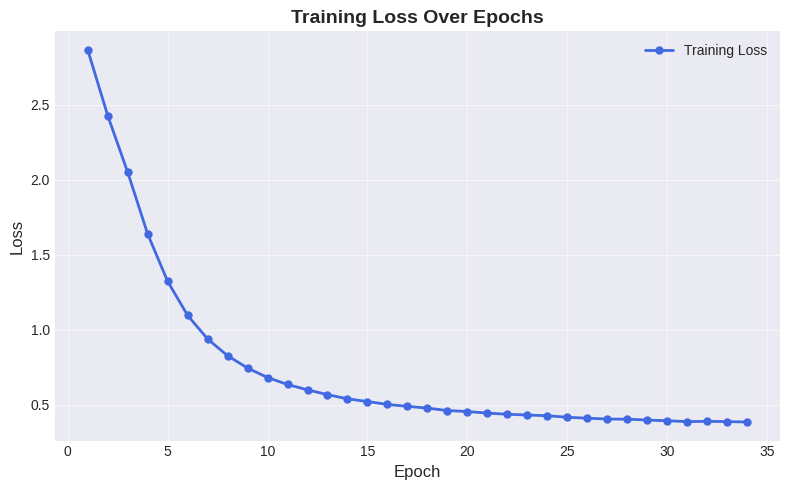

In [23]:
epochs = range(1, len(training_losses) + 1)
plt.style.use("seaborn-v0_8-darkgrid")

plt.figure(figsize=(8, 5))
plt.plot(epochs, training_losses, 'o-', color='royalblue', lw=2, markersize=5, label='Training Loss')

plt.title('Training Loss Over Epochs', fontsize=14, weight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(alpha=0.6)
plt.tight_layout()

plt.savefig('training_loss.png', dpi=300)
plt.show()

# **Save Embeddings and Word to Index Dictionary**

In [35]:
embeddings = model.embeddings.weight.detach()
torch.save(embeddings, "embeddings.pt")

with open("word_to_idx.pkl", "wb") as f:
    pickle.dump(word_to_idx, f)

print("✅ Embeddings and word_to_idx saved successfully!")

✅ Embeddings and word_to_idx saved successfully!


# **Load Embeddings and Word to Index Dictionary**

In [36]:
embeddings = torch.load("embeddings.pt")

with open("word_to_idx.pkl", "rb") as f:
    word_to_idx = pickle.load(f)

print("✅ Embeddings and word_to_idx loaded successfully!")

✅ Embeddings and word_to_idx loaded successfully!


# **Visual Word Analogy**

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch

def plot_target_based_analogy(embeddings, word_to_idx, words, save_path):
    """
    Plots an analogy using a "Target-Based" projection.
    The X-axis IS the target vector's direction.
    The Y-axis IS the error/perpendicular direction.
    This method *guarantees* that a Cosine Similarity of 1.0
    will show a perfect overlap.
    """
    missing = [w for w in words if w not in word_to_idx]
    if missing:
        print(f"Skipping '{save_path}': missing {missing}")
        return

    # 1. Get the high-dimensional vectors
    A, B, C, D = [embeddings[word_to_idx[w]] for w in words]
    result_vec = (B - A + C)
    target_vec = D
    
    # 2. Calculate metrics in high-D space
    # (Move to numpy for scikit-learn and linalg)
    result_np = result_vec.cpu().numpy()
    target_np = target_vec.cpu().numpy()
    
    cosine_sim = cosine_similarity([result_np], [target_np])[0, 0]
    euclidean_dist = np.linalg.norm(result_np - target_np)

    # 3. Create the new 2D axes
    # X-axis is the normalized target vector
    x_axis_vec = target_np / (np.linalg.norm(target_np) + 1e-9)
    
    # Y-axis is the part of the result_vec that is *perpendicular* to the x_axis_vec
    # This is the "error" vector
    y_component = result_np - (np.dot(result_np, x_axis_vec) * x_axis_vec)
    
    # Check if the error is basically zero (perfect alignment)
    if np.linalg.norm(y_component) < 1e-9:
        # The vectors are collinear! We have to invent a
        # perpendicular y-axis. We just pick one.
        y_axis_vec = np.array([-x_axis_vec[1], x_axis_vec[0], *x_axis_vec[2:]])
        if x_axis_vec.shape[0] > 2: # Make sure it's orthogonal in n-D
             y_axis_vec[2] = 0 
        y_axis_vec = y_axis_vec / (np.linalg.norm(y_axis_vec) + 1e-9)
    else:
        y_axis_vec = y_component / (np.linalg.norm(y_component) + 1e-9)

    # 4. Project the two vectors onto these new 2D axes
    # The (x, y) coordinates for our plot
    p_result_x = np.dot(result_np, x_axis_vec)
    p_result_y = np.dot(result_np, y_axis_vec)
    
    p_target_x = np.dot(target_np, x_axis_vec)
    p_target_y = np.dot(target_np, y_axis_vec) # This will be 0 or very close to it
    
    p_result = np.array([p_result_x, p_result_y])
    p_target = np.array([p_target_x, p_target_y])

    # --- Start Plotting ---
    fig, ax = plt.subplots(figsize=(10, 8)) 

    # Plot Arrows from Origin
    ax.add_patch(FancyArrowPatch((0, 0), (p_result[0], p_result[1]),
                                 color='blue', mutation_scale=20, lw=2,
                                 arrowstyle='-|>', zorder=5,
                                 label=f"Result: {words[1]} - {words[0]} + {words[2]}"))

    ax.add_patch(FancyArrowPatch((0, 0), (p_target[0], p_target[1]),
                                 color='red', mutation_scale=20, lw=2,
                                 arrowstyle='-|>', zorder=5,
                                 label=f"Target: {words[3]}"))

    # --- Adjust plot limits to include origin ---
    ax.autoscale_view()
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    max_range = max(abs(x_min), abs(x_max), abs(y_min), abs(y_max)) * 1.2
    max_range = max(max_range, 0.1) # Set a minimum range
    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)

    # --- CRITICAL FIX: Ensure 1:1 Aspect Ratio ---
    ax.set_aspect('equal', 'box')

    # --- Text Labels ---
    text_offset = max_range * 0.03
    ax.text(p_result[0] + text_offset, p_result[1], 
            f"Result",
            fontsize=10, ha='left', va='bottom', color='blue', weight='bold')

    ax.text(p_target[0] + text_offset, p_target[1], 
            f"Target ({words[3]})",
            fontsize=10, ha='left', va='bottom', color='red', weight='bold')

    # --- Legends ---
    leg1 = ax.legend(loc='upper right', title="Vectors", fontsize=10, framealpha=0.8)
    ax.add_artist(leg1)

    legend_elements = [
        Line2D([0], [0], color='w', marker='', linestyle='',
               label=f"Cosine Similarity: {cosine_sim:.3f}"),
        Line2D([0], [0], color='w', marker='', linestyle='', 
               label=f"Euclidean Distance: {euclidean_dist:.3f}")
    ]
    ax.legend(handles=legend_elements, loc='lower left', title="Metrics (High-D)", fontsize=10, framealpha=0.8)
    
    # Plot the origin point and axes
    ax.plot(0, 0, 'ko', markersize=6, zorder=6, label='_nolegend_') # Black dot at origin
    ax.axhline(0, color='black', lw=0.5, alpha=0.5, zorder=0)
    ax.axvline(0, color='black', lw=0.5, alpha=0.5, zorder=0)

    # --- Title and Grid ---
    title = f"Analogy: Target-Based Projection\nResult: {words[1]} - {words[0]} + {words[2]}  |  Target: {words[3]}"
    ax.set_title(title, fontsize=14, weight='bold', pad=20) 
    ax.grid(alpha=0.4)
    
    ax.set_xlabel(f"Direction of '{words[3]}' (Target)", fontsize=10)
    ax.set_ylabel("Perpendicular Error", fontsize=10)

    plt.tight_layout()
    plt.show()
    fig.savefig(save_path)
    plt.close(fig)

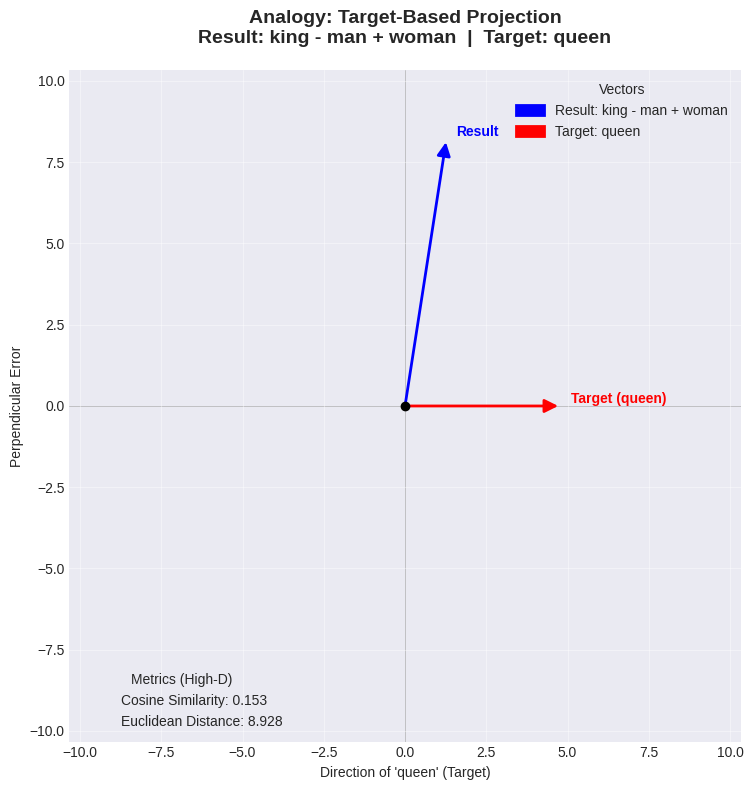

Skipping 'analogy_2.png': missing ['boy', 'brother', 'girl', 'sister']
Skipping 'analogy_3.png': missing ['father', 'mother']
Skipping 'analogy_4.png': missing ['walk', 'walking', 'swim', 'swimming']
Skipping 'analogy_5.png': missing ['run', 'running', 'eat', 'eating']
Skipping 'analogy_6.png': missing ['good', 'better', 'bad', 'worse']
Skipping 'analogy_7.png': missing ['big', 'bigger', 'small', 'smaller']
Skipping 'analogy_8.png': missing ['strong', 'stronger', 'weak', 'weaker']


In [38]:
analogies = [
    ["man", "king", "woman", "queen"],
    ["boy", "brother", "girl", "sister"],
    ["father", "man", "mother", "woman"],
    ["walk", "walking", "swim", "swimming"],
    ["run", "running", "eat", "eating"],
    ["good", "better", "bad", "worse"],
    ["big", "bigger", "small", "smaller"],
    ["strong", "stronger", "weak", "weaker"]
]

plt.style.use("seaborn-v0_8-darkgrid")

for i, words in enumerate(analogies, 1):
    # Call the new function directly
    plot_target_based_analogy(embeddings, word_to_idx, words, f"analogy_{i}.png")

In [52]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch

def get_similarity(w1, w2, embeddings, word_to_idx):
    """Calculates and prints the cosine similarity between two words (handles both torch and numpy)."""
    
    # Check if words exist in vocab
    if w1 not in word_to_idx or w2 not in word_to_idx:
        print(f"Error: One or both words '{w1}', '{w2}' not in vocabulary.")
        return

    # Extract embeddings
    vec1 = embeddings[word_to_idx[w1]]
    vec2 = embeddings[word_to_idx[w2]]

    # Convert to NumPy if PyTorch tensors
    if torch.is_tensor(vec1):
        vec1 = vec1.detach().cpu().numpy()
        vec2 = vec2.detach().cpu().numpy()

    # Reshape to (1, -1) for sklearn
    vec1 = vec1.reshape(1, -1)
    vec2 = vec2.reshape(1, -1)
    
    # Compute cosine similarity
    sim = cosine_similarity(vec1, vec2)[0][0]
    print(f"Cosine Similarity ('{w1}' vs. '{w2}'): {sim:.4f}")


In [53]:
get_similarity("king", "king", embeddings, word_to_idx)
get_similarity("galaxy", "keyboard", embeddings, word_to_idx)
get_similarity("river", "queen", embeddings, word_to_idx)
get_similarity("man", "keyboard", embeddings, word_to_idx)

Cosine Similarity ('king' vs. 'king'): 1.0000
Error: One or both words 'galaxy', 'keyboard' not in vocabulary.
Cosine Similarity ('river' vs. 'queen'): 0.3176
Error: One or both words 'man', 'keyboard' not in vocabulary.


In [50]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_analogies(embeddings, word_to_idx, analogies):
    for w1, w2, w3, expected in analogies:
        # Check all words exist
        missing = [w for w in [w1, w2, w3, expected] if w not in word_to_idx]
        if missing:
            print(f"Skipping analogy ({w1}, {w2}, {w3}, {expected}): missing {missing}")
            continue
        
        # Get embeddings (works for PyTorch or NumPy)
        vec1 = embeddings[word_to_idx[w1]]
        vec2 = embeddings[word_to_idx[w2]]
        vec3 = embeddings[word_to_idx[w3]]
        vec_expected = embeddings[word_to_idx[expected]]
        
        # --- Convert to NumPy if torch tensor ---
        if not isinstance(vec1, np.ndarray):
            vec1 = vec1.detach().cpu().numpy()
            vec2 = vec2.detach().cpu().numpy()
            vec3 = vec3.detach().cpu().numpy()
            vec_expected = vec_expected.detach().cpu().numpy()
        
        # Compute analogy vector
        result_vec = vec2 - vec1 + vec3  # king - man + woman
        
        # Cosine similarity
        cos_sim = cosine_similarity(
            result_vec.reshape(1, -1),
            vec_expected.reshape(1, -1)
        )[0][0]
        
        print(f"{w2} - {w1} + {w3} ≈ {expected} | Cosine Similarity = {cos_sim:.4f}")


In [51]:
# Suppose you have:
# embeddings: a NumPy array of shape (vocab_size, embed_dim)
# word_to_idx: a dict mapping words to indices
# and your analogies list:

analogies = [
    ["man", "king", "woman", "queen"],
    ["boy", "brother", "girl", "sister"],
    ["father", "man", "mother", "woman"],
    ["walk", "walking", "swim", "swimming"],
    ["run", "running", "eat", "eating"],
    ["good", "better", "bad", "worse"],
    ["big", "bigger", "small", "smaller"],
    ["strong", "stronger", "weak", "weaker"]
]

evaluate_analogies(embeddings, word_to_idx, analogies)


king - man + woman ≈ queen | Cosine Similarity = 0.1734
brother - boy + girl ≈ sister | Cosine Similarity = 0.2842
man - father + mother ≈ woman | Cosine Similarity = 0.2033
Skipping analogy (walk, walking, swim, swimming): missing ['swim']
Skipping analogy (run, running, eat, eating): missing ['eat']
Skipping analogy (good, better, bad, worse): missing ['worse']
Skipping analogy (big, bigger, small, smaller): missing ['bigger']
stronger - strong + weak ≈ weaker | Cosine Similarity = 0.2454
